# MAUI Oscilloscope controller

The middle to high-end Teledyne-LeCroy oscilloscope come with the MAUI (Most Advanced User Interface) control interface. Each of these MAUI-enabled scopes can be controlled in the same way, assuming they have the same functionality, etc. The `MAUI` class presents a control interface to remotely access and setup an oscilloscope. Not every functionality is incorporated at this point, but the most imporant and basic ones are, i.e.:
 * General Oscilloscope controls, i.e., triggering
 * Channels
 * Math functions
 * Measurement setup and data retrieval
 * Waveform retrieval
Here, some detailed examples for various applications are shown. 

## Communications
These Oscilloscopes have many different ways of communicating with the host computer. This class only supports the `LXI (VXI11)` protocol, which should come by default on theses oscilloscopes. The reason for this is that this protocoll supports the NI-VISA protocol, which can be completely replaced with the open PyVISA. Thus the oscilloscope can be controlled from any OS, in fact, most of the development have taken place on Linux. *Note*: The scope that the software was developed with is an older wavesurfer 3054, which was at least supposed to support the `LXI (VXI11)` protocol. However, it could not be activated. After contacting Teledyne-LeCroy, they responded fairly quickly and sent an activation code to enable the protocol, free of charge.

In order to successfully communicate with the oscilloscope, PyVISA requires the [pyvisa-py](https://pyvisa-py.readthedocs.io/en/latest/) backend. This should be the requirements for the package now. If not or not yet installed on your setup, you can install it by typing:

    pip install pyvisa-py

## Importing the pre-requisites
First let's import some packages that we'll need, mostly instrumentkit of course :)

In [1]:
import sys, os

# if you run this script from a cloned InstrumentKit path without a full installation, leave the following line in
sys.path.insert(0, os.path.abspath('../../'))

# import the instrument kit
import instruments as ik
import instruments.units as u

# imports for specific functions in this script
import matplotlib.pyplot as plt
from time import sleep

## Enabling the oscilloscope

First let us look at how to establish communications with the oscilloscope. ON the oscilloscope itself, go to `Utilities` -> `Utilities Setup` -> `Remote` and select on the left side the `LXI (VXI11)` communications protocol. Connect the oscilloscope to your local area network and check it's IP address. The example IP address that will be used here is `192.168.8.154`.

Then you can load the oscilloscope and enable communications in the following way:

In [2]:
inst = ik.teledyne.MAUI.open_visa("TCPIP0::192.168.0.10::INSTR")

## Specifying your oscilloscope setup

The MAUI interface works for mulitple different Teledyne-LeCroy oscilloscopes. Not all of these oscilloscopes will have the same options, so some commands might not be available on your scope. To make the oscilloscope controller versatile, the number of available channels (default 4), available functions (default 2), and available measurements (default 6) can be adjusted. The number of channels is simply how many inputs are available on the front. The number of functions is how many functions can be set up in the scopes math menu, usually labeled as `F1`, ... `Fn` in th oscilloscope software. The number of available measurements is the number of measurements that can be configured on the scope, usually labeled as `P1`, ... `Pn`.

In [3]:
# setting and getting the number of channels
inst.number_channels = 4
inst.number_channels

4

In [4]:
# setting and getting the number of functions
inst.number_functions = 2
inst.number_functions

2

In [5]:
# setting and getting the number of measurements
inst.number_measurements = 6
inst.number_measurements

6

## Triggering the scope

The simplest possible way to stop and start the oscilloscope from triggering is as following:

In [6]:
# stop the oscilloscope from triggering
inst.stop()

In [7]:
# start the oscilloscope in automatic triggering mode
inst.run()

However, the four triggering states can also be controlled manually. These states are: automatic triggering `auto`, normal triggering `normal`, a single trigger `single` and no triggering `stop`. These trigger states are implemented as a `inst.TriggerState` subclass under the instrument class. Reading the trigger state (should be `auto` from just before) and then setting it to `normal` can be done in the following way:

In [8]:
# get the current trigger state
inst.trigger_state

<TriggerState.auto: 'AUTO'>

In [9]:
# restart the trigger with a single trigger
inst.trigger_state = inst.TriggerState.normal

In addition, e.g., for a measurement, a trigger can also be forced upon request. For this to work, set the oscilloscope into stop mode, then force a trigger.

In [10]:
# Stop the triggering
inst.stop()

# A trigger can also be forced by calling:
inst.force_trigger()

The oscilloscope will be put back into stopped mode. To continue triggering in normal mode, run:

In [11]:
inst.trigger_state = inst.TriggerState.normal

In addition to selecting the triggering state, the triggering source, type, and level can also be chosen. For most oscilloscopes, all channels and an external triggering source can be chosen from, optional settings are possible. Possible triggering sources are stored in the `enum` class `TriggerSource`, while triggering types are stored in the `TriggerType` `enum` class.

Let's set the triggering source to the external trigger and trigger on the edge. This can be accomplished with the following commands:

In [12]:
inst.trigger_source = inst.TriggerSource.ext
inst.trigger_type = inst.TriggerType.edge

## Time base

The timebase is the same for all channels and therefore implemented on the instrument level. Setting the timebase of the scope expects a unitful value. If no units are given, seconds are assumed. To set the time per division to 20 ns and read it back out, run the following commands.

In [13]:
inst.time_div = u.Quantity(20, u.ns)
inst.time_div

array(2.e-08) * s

To shift the timebase with respect to the trigger, a trigger delay can be called. This call is unitful as well. To set a trigger delay of 60 ns and read it back, run the following command.

In [14]:
inst.trigger_delay = u.Quantity(60, u.ns)
inst.trigger_delay

array(6.e-08) * s

## Controlling a channel

To control a channel, several functions are implemented. The first channel is referred to as `0`, as is common in python. To create an instance of the first channel you can run:

In [15]:
channel = inst.channel[0]

Turning a trace on and off can be done by setting the `channel.trace` with a bool. For example, to turn the trace on (no matter what state it is in) and then read its state back, run

In [16]:
channel.trace = True
channel.trace

True

Control over the coupling of the specific channel is supplied via the `channel.Coupling` class. To set the coupling to $50\,\Omega$ and then read it back, run the following commands:

In [17]:
channel.coupling = channel.Coupling.dc50
channel.coupling

<Coupling.dc50: 'D50'>

The scale (i.e., the volts per division) of a channel can be set unitful as well. If no units are given it is assumed that the user means Volts per division. To set the scale to 1 V per division and read its state back, run

In [18]:
channel.scale = u.Quantity(1, u.V)
channel.scale

array(1.) * V

In the same manner, the trace can also be shifted to, let's say -2950 mV in vertical position. This offset can be set / read as following:

In [19]:
channel.offset = u.Quantity(-2950, u.mV)
channel.offset

array(-2.95) * V

Finally, after having gone through all configurations, the waveform can be read back to the computer. The waveform is reutrned as a two dimensional numpy array representing the timebase and the signal. We can directly unpack the waveform via:

In [20]:
timebase, signal = channel.read_waveform()

Furthermore we know that the signal has been shifted by -2.95 V in the negative direction and by 60 ns in the positive time base direction. Let's see how the signal looks.

Text(0, 0.5, 'Signal (V)')

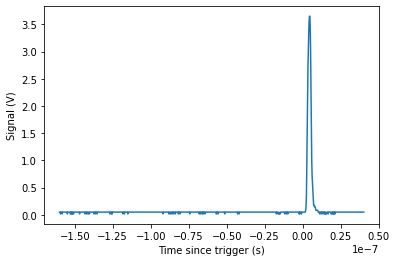

In [21]:
plt.plot(timebase, signal)
plt.xlabel("Time since trigger (s)")
plt.ylabel("Signal (V)")

The offset in horizontal and vertical access are automatically taken into account such that the signal that is returned can directly be interpreted in time relative to the trigger and in the signal in absolute voltage. Clearly, this peak is almost 4 V heigh and very short. Let us move the peak in horizontal and vertical direction to the center of the oscilloscope display and read back one waveform with 1 V per division on the vertical axis and one waveform with 250 mV per division. The latter will surely clip the peak at the top.

Text(0.5, 1.0, '1 V / division: Signal visible')

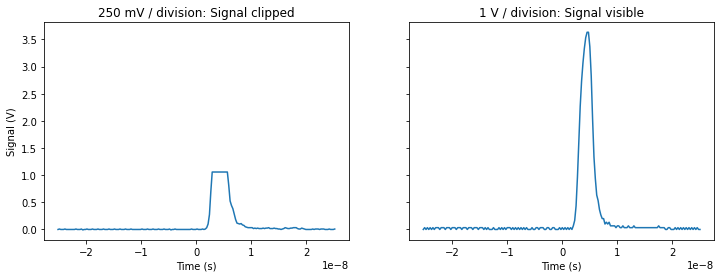

In [22]:
# set offsets to zero
inst.trigger_delay = 0
channel.offset = 0

# set horizontal axis to 5 ns per division
inst.time_div = u.Quantity(5, u.ns)

# set to 250 mV per division and read waveform back
channel.scale = u.Quantity(250, u.mV)
x1, y1 = channel.read_waveform()

# allow for 250 ms to not have it read to fast
sleep(0.25)

# set to 1 V per division and read the waveform back
channel.scale = u.Quantity(1, u.V)
x2, y2 = channel.read_waveform()

# plot the results
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,4))

ax[0].plot(x1, y1)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Signal (V)")
ax[0].set_title("250 mV / division: Signal clipped")
ax[1].plot(x2, y2)
ax[1].set_xlabel("Time (s)")
ax[1].set_title("1 V / division: Signal visible")

Clearly, the left signal is clipped on top. This results from the fact that the signal did not fit on the oscilloscope screen. If the signal is off scale, the data returned is simple the largest possible one, in this case, full signal. Since we artificially scale the two figures to the same y scale, this of course does not show up on top but at 1 V, which is equivalent to 4 divisions up.

**Remember**: Reading a wave form only returns the data that is displayed on the oscilloscope screen.

## Math functions

Many math functions are available on these oscilloscopes, depending on the options that the oscilloscope is shipped with, more or less functions are available. For an overview of the implemented functions and how they work, have a look at the InstrumentKit documentation. You will find all functions in the `Math.Operators` subclass.

For now, let's set up averaging of the first channel.

In [23]:
# Access the first math function `F1`
function = inst.math[0]

# turn on the trace of this math function
function.trace = True

# set it to averaging of channel 1 (0 in python)
function.operator.average(('C', 0))

This will have set up the first function to average the first channel. The parameter that is passed on to to average, the required parameter, is the source it should average. Different operators have of course different parameters that are required / optional. 

**Note**: There are two ways that sources can be specified. If an integer is given, it is assumed that the source is a channel. Alternatively another source, e.g., a math function could also be defined. This would be done by submitting a tuple, i.e., `('F', 0)` to select the first math function (called `F1` in the oscilloscope).

To check if this all worked we can read back the channel itself and the average math function and plot the results.

Text(0.5, 1.0, 'Average of the channel (math)')

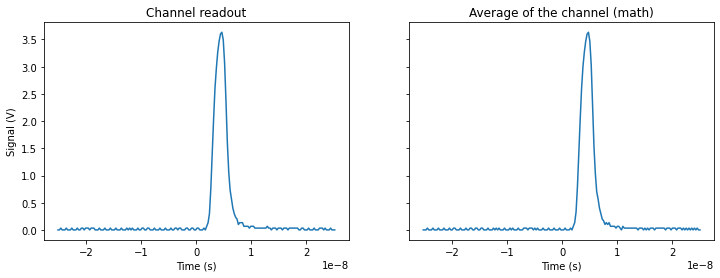

In [24]:
# read channel
x_ch, y_ch = channel.read_waveform()

# allow for 250 ms to not have it read to fast
sleep(0.25)

# read math
x_math, y_math = function.read_waveform()

# plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

ax[0].plot(x_ch, y_ch)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Signal (V)")
ax[0].set_title("Channel readout")
ax[1].plot(x_math, y_math)
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Average of the channel (math)")

With a poorer signal generator, the average should look a lot smoother than the channel. To finish up the math section, let's turn off the math trace.

In [25]:
function.trace = False

## Measurements and statistics

In addition to mathematical operations on channels, oscilloscopes can take measurements and display the statistics. Many measurement parameters are already implemented, check out the documentation and look for the `inst.MeasurementParameters` class. Currently, only measurement parameters that act on a single source are available.

As an example, let us set up 2 measurements. Measurement 1 determines the rise time (10% to 90%), measurement 2 the fall time (80% to 20%) of the first channel readout. Setting up the measurement can be done as following:

In [26]:
# assign the two measurements
msr1 = inst.measurement[0]
msr2 = inst.measurement[1]

# turn on the measurements (only one is really necessary, the other one is turned on automatically!)
msr1.measurement_state = msr1.State.both

# assign the measurement types and which source the measurement should be on
msr1.set_parameter(inst.MeasurementParameters.rise_time_10_90, 0)
msr2.set_parameter(inst.MeasurementParameters.fall_time_80_20, 0)

The oscilloscope will now automatically set up these measurements and will start accumulating statistics. The statistics can be returned at any point, which will return a tuple containing 5 floats. These floats are:

 1. Average
 2. Lowest value measured
 3. Highest value measured
 4. Standard deviation
 5. Number of sweeps
 
These returns are not unitful, so you will need to know what was set up. For the rise and fall times, the returns will of course be in the form of time. SI units are always returned, in this case, seconds.

In [27]:
msr1.statistics

(1.52152e-09, 1.49e-09, 1.56e-09, 2.553e-11, 4.0)

In [28]:
msr2.statistics

(9.6247e-10, 9.02e-10, 1.01e-09, 2.415e-11, 24.0)

To start a new series of measurements, i.e., reset the number of sweeps, the following command can be executed:

In [29]:
inst.clear_sweeps()

# getting statistics for `msr1` again:
msr1.statistics

(1.56e-09, 1.56e-09, 1.56e-09, 0.0, 1.0)

To delete the measurement parameters again and turn off the table, the following commands are used:

In [30]:
# delete parameters
msr1.delete()
msr2.delete()

# turn off measurement
msr1.measurement_state = msr1.State.off

## Further information

Please check out the documention on [readthedocs.io](https://instrumentkit.readthedocs.io/en/latest/) and feel free to open an issue on the github repository if you have any problems / feature requests.